# Question 3 – Air Passengers Forecasting with ARIMA/SARIMA
Dataset: `air-passengers.csv`.

We now focus on ARIMA and SARIMA models.

In [1]:
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

def load_air_passengers():
    for p in ['air-passengers.csv', 'air_passengers.csv', '/mnt/data/air-passengers.csv', '/mnt/data/air_passengers.csv']:
        if os.path.exists(p):
            path = p
            break
    else:
        raise FileNotFoundError('air-passengers.csv not found')
    df = pd.read_csv(path)
    date_col_candidates = [c for c in df.columns if 'date' in c.lower() or 'month' in c.lower()]
    date_col = date_col_candidates[0] if date_col_candidates else df.columns[0]
    value_col_candidates = [c for c in df.columns if 'passenger' in c.lower() or 'value' in c.lower()]
    value_col = value_col_candidates[0] if value_col_candidates else df.columns[1]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col).asfreq('MS')
    df = df.rename(columns={value_col: 'Passengers'})
    return df

air_ts = load_air_passengers()
air_ts.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 3(a) Question – Why Pure AR(p) or MA(q) Are Not Enough
> A forecast is going to be made for the total number of monthly passengers using autocorrelation
> models. Why, in this case, are pure AR(p) or MA(q) models not suitable for forecasting?

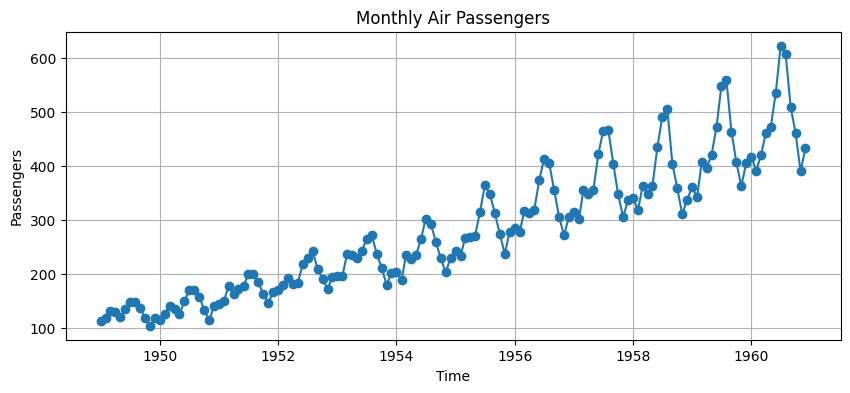

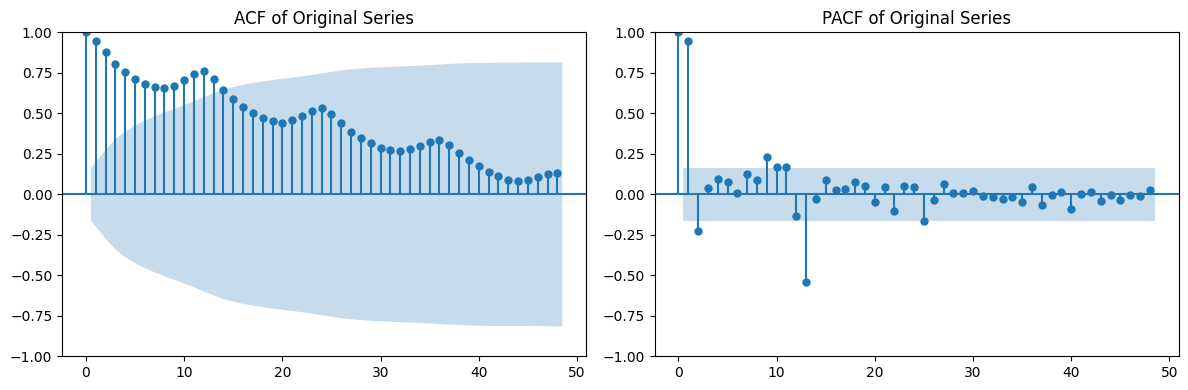

In [2]:
# 3(a) – Visualize series, ACF, and PACF

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(air_ts.index, air_ts['Passengers'], marker='o', linestyle='-')
ax.set_title('Monthly Air Passengers')
ax.set_xlabel('Time')
ax.set_ylabel('Passengers')
ax.grid(True)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(air_ts['Passengers'], lags=48, ax=axes[0])
axes[0].set_title('ACF of Original Series')
plot_pacf(air_ts['Passengers'], lags=48, ax=axes[1], method='ywm')
axes[1].set_title('PACF of Original Series')
plt.tight_layout()
plt.show()

### 3(a) Explanation

The air-passengers series has:
- Strong **upward trend** (non-constant mean).
- Clear **seasonality** with period 12.
- Changing variance (amplitude grows over time).

Pure AR(p) or MA(q) models assume **stationarity** and do not explicitly handle **seasonal patterns**. Even after
differencing to remove trend, the remaining series has strong seasonal autocorrelation.

Therefore, we need models that combine non-seasonal and seasonal components: **ARIMA** for non-seasonal part and
**SARIMA** with $(P,D,Q)_m$ seasonal terms to capture 12-month seasonality.

## 3(b) Question – ARIMA or SARIMA, Parameter Selection, Implementation
> Which method is more suitable, ARIMA or SARIMA? Explain. How do you determine the best
> parameters? Implement code to fit the best model using the last 12 months as test data.

c:\MyProjects\SGUProjects\Final_Data_Mining_Project\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\MyProjects\SGUProjects\Final_Data_Mining_Project\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\MyProjects\SGUProjects\Final_Data_Mining_Project\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\MyProjects\SGUProjects\Final_Data_Mining_Project\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

Best order (p,d,q): (1, 1, 0)
Best seasonal (P,D,Q,m): (0, 1, 0, 12)
Best AIC: -406.0136871185539


c:\MyProjects\SGUProjects\Final_Data_Mining_Project\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


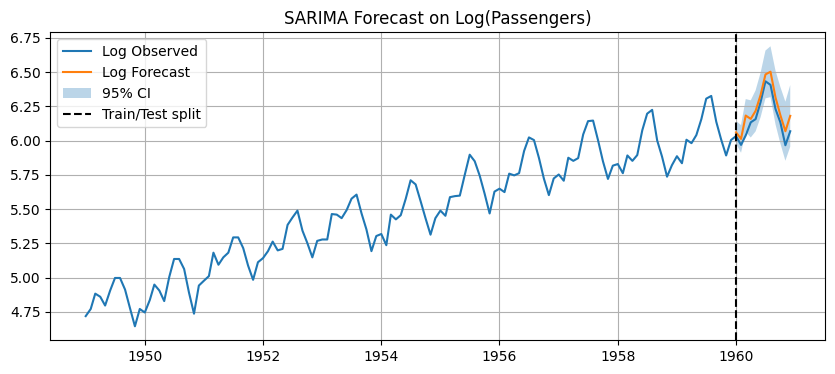

In [3]:
# 3(b) – Fit SARIMA with simple grid search

air_ts['log_passengers'] = np.log(air_ts['Passengers'])

train = air_ts.iloc[:-12]['log_passengers']
test = air_ts.iloc[-12:]['log_passengers']

p_values = [0,1,2]
d_values = [1]
q_values = [0,1,2]
P_values = [0,1]
D_values = [1]
Q_values = [0,1]
m = 12

best_aic = np.inf
best_order = None
best_seasonal = None
best_model = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        order = (p,d,q)
                        seasonal = (P,D,Q,m)
                        try:
                            model = SARIMAX(train, order=order, seasonal_order=seasonal,
                                            enforce_stationarity=False, enforce_invertibility=False)
                            res = model.fit(disp=False)
                            if res.aic < best_aic:
                                best_aic = res.aic
                                best_order = order
                                best_seasonal = seasonal
                                best_model = res
                        except Exception:
                            continue

print("Best order (p,d,q):", best_order)
print("Best seasonal (P,D,Q,m):", best_seasonal)
print("Best AIC:", best_aic)

pred = best_model.get_forecast(steps=12)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(air_ts.index, air_ts['log_passengers'], label='Log Observed')
ax.plot(test.index, pred_mean, label='Log Forecast')
ax.fill_between(test.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=0.3, label='95% CI')
ax.axvline(test.index[0], color='k', linestyle='--', label='Train/Test split')
ax.set_title('SARIMA Forecast on Log(Passengers)')
ax.legend()
ax.grid(True)
plt.show()

### 3(b) Explanation – Why SARIMA and How to Choose Parameters

- Because the data exhibit **trend and seasonality**, **SARIMA** (seasonal ARIMA) is more suitable than plain ARIMA.
- SARIMA$(p,d,q) \times (P,D,Q)_m$ includes:
  - Non-seasonal AR/MA orders $(p,q)$ and differencing $d$.
  - Seasonal AR/MA orders $(P,Q)$, seasonal differencing $D$, and period $m=12$.

Parameter selection procedure:
1. Use plots and prior knowledge to set $d$ and $D$ (often $d=1$, $D=1$ for this series).
2. Try small grids of $(p,q)$ and $(P,Q)$.
3. For each candidate, fit the model and compute **AIC / AICc**.
4. Choose the model with the **lowest AIC** and check residuals.

The code does exactly this on a small grid and prints the best combination.

## 3(c) Question – Measuring Model Performance
> How do you measure whether your model has good performance? Implement code to compute this
> measure for the model obtained in (b).

In [4]:
# 3(c) – Evaluate SARIMA forecast using MAPE

pred = best_model.get_forecast(steps=12)
pred_mean = pred.predicted_mean

test_actual = np.exp(test)
test_pred = np.exp(pred_mean)

mape = mean_absolute_percentage_error(test_actual, test_pred) * 100
print("Test MAPE (%):", mape)

Test MAPE (%): 7.41447857508787


### 3(c) Explanation – Forecast Accuracy

For positive-valued series like passenger counts, **MAPE** is an interpretable measure:
$$ \text{MAPE} = \frac{100\%}{n} \sum_{t=1}^n \left| \frac{y_t - \hat{y}_t}{y_t} \right|. $$

We compute MAPE on the last 12 months (test set). A **smaller MAPE** indicates better forecasting performance.
We would normally compare this MAPE with simpler benchmarks (naïve, exponential smoothing) to see if SARIMA brings
a real improvement.